# Import data and preprocessing

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from pathlib import Path
from lightkurve import KeplerLightCurveFile
import math
from gatspy.periodic import *

/opt/homebrew/lib/python3.14/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


In [2]:
path_to_files = "/Users/tmishra/Downloads/roto2.0/roto-project/MAST_2025-10-23T2232/MAST_2025-10-23T2232/Kepler/kplr005110407_lc_Q001111011101110111/kplr005110407_lc_Q001111011101110111_all_files/005110407"

In [3]:
folder = Path(path_to_files)

# find all .fits files in the folder (non-recursive)
fits_files = list(folder.glob("*.fits"))

In [4]:
light_curves= []
for file in fits_files:
    lcfile = KeplerLightCurveFile(file)
    lc = lcfile.PDCSAP_FLUX.remove_nans()
    light_curves.append(lc)

/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_29789/2159991908.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_29789/2159991908.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_29789/2159991908.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_29789/2159991908.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcfile.PDCSAP_FLUX.remove_nans()
/var/folders/jk/y277gdtn4v16jhh80rvcq17s08jmmm/T/ipykernel_29789/2159991908.

4473
4609
3550
4108
1284
4366
4134
3535
4486
4226
3106
4243
4070


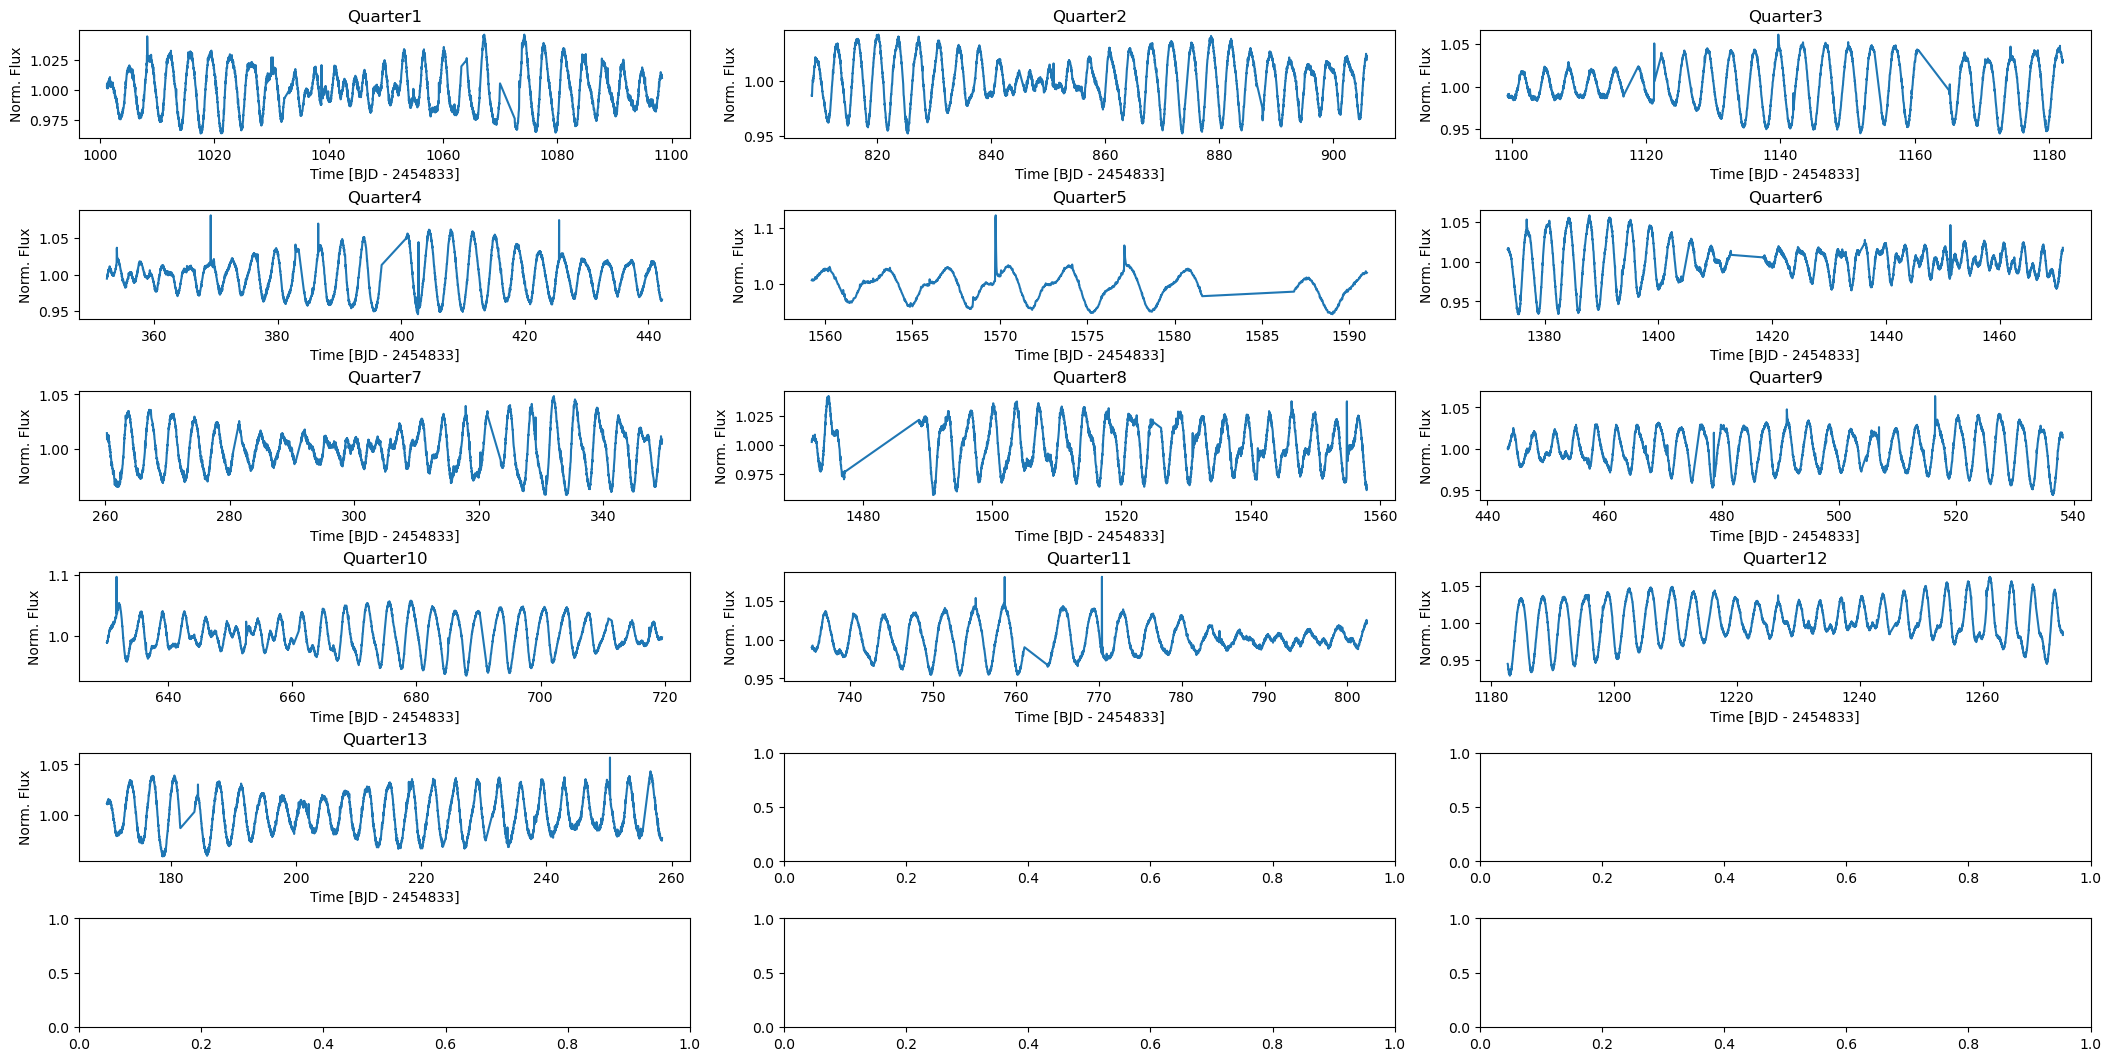

In [5]:
cols = 6
rows = math.ceil(len(light_curves) / cols)

# Create figure
fig, axes = plt.subplots(cols, rows, figsize=(3.5 * cols, 3.5 * rows), layout="constrained")
axes = axes.flatten()  # flatten grid to simple list

# Loop over files and axes
for i,(lc, ax) in enumerate(zip(light_curves, axes)):
    # Normalize
    flux = lc.flux.value / np.nanmedian(lc.flux.value)
    time = lc.time.value
    # Plot each quarter
    ax.plot(time, flux) # shows quarter start time
    ax.set_title("Quarter" + str(i+1))
    ax.set_xlabel("Time [BJD - 2454833]")
    ax.set_ylabel("Norm. Flux")
    
plt.show()

Number of points: 4473


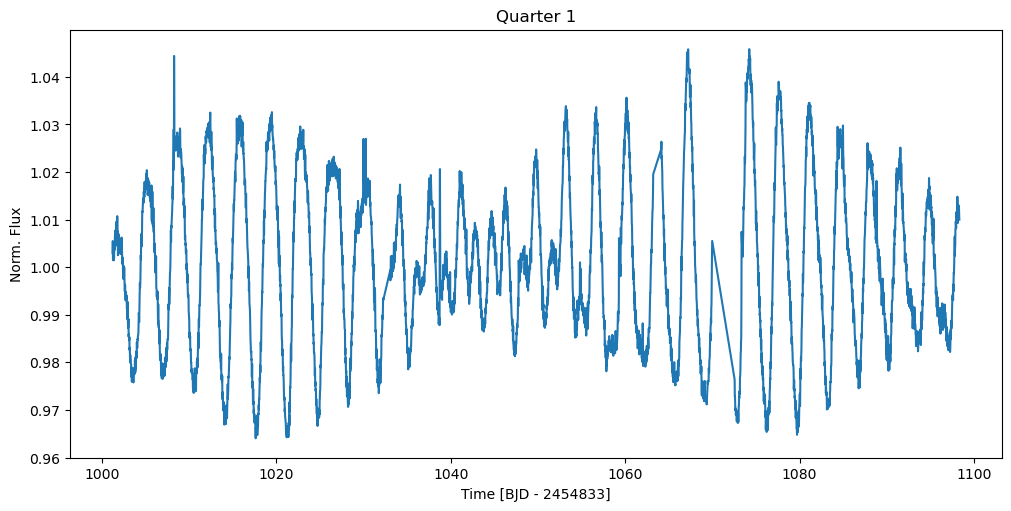

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout="constrained")

# Just plot the first light curve
lc = light_curves[0]

# Normalize
flux = lc.flux.value / np.nanmedian(lc.flux.value)
time = lc.time.value

print(f"Number of points: {len(flux)}")

# Plot this quarter
ax.plot(time, flux)
ax.set_title("Quarter 1")
ax.set_xlabel("Time [BJD - 2454833]")
ax.set_ylabel("Norm. Flux")

plt.show()

In [8]:
# Install tinygp: pip install tinygp jax jaxlib
import jax
import jax.numpy as jnp
from jax import jit
import tinygp
from tinygp import kernels, GaussianProcess
from scipy.optimize import minimize

print("tinygp imported successfully")

tinygp imported successfully


## Gaussian Process Implementation

We'll use a **quasi-periodic kernel** 

In [14]:
@jit
def neg_log_likelihood(params_array, time, flux, flux_err):
    """
    Negative log likelihood for optimization.
    
    params_array: [log_period, log_length, log_gamma]
    """
    # Unpack parameters
    period = jnp.exp(params_array[0])
    length = jnp.exp(params_array[1])
    gamma = jnp.exp(params_array[2])
    
    # Build kernel - FIXED: scale=period, gamma=gamma
    kernel_periodic =  kernels.ExpSineSquared(scale=period, gamma=gamma)
    kernel_smooth = kernels.Matern32(scale=length)
    kernel = kernel_periodic + kernel_smooth
    
    # Build GP with measurement errors
    gp = GaussianProcess(kernel, time, diag=flux_err)
    
    # Compute log likelihood
    return -gp.log_probability(flux)

# Gradient for optimization
grad_nll = jax.grad(neg_log_likelihood, argnums=0)

print("Loss function defined")

Loss function defined


In [15]:
def find_period_gp(lc, initial_period=3.5, verbose=True):
    """
    Find rotation period using Gaussian Process.
    
    Parameters:
    -----------
    lc : lightkurve object
    initial_period : float (days)
    
    Returns:
    --------
    dict with 'period', 'params', 'time', 'flux', 'success', 'trajectory'
    """
    # Extract and clean data
    time = lc.time.value
    flux = lc.flux.value
    
    # Normalize to ppt
    flux = (flux / np.nanmedian(flux) - 1) * 1e3
    flux_err = lc.flux_err.value # 1 ppt noise assumption
    
    # Convert to JAX
    time_jax = jnp.array(time)
    flux_jax = jnp.array(flux)
    flux_err_jax = jnp.array(flux_err)
    
    # Initial parameters [log_period, log_length, log_gamma]
    # Removed amp and noise - calculated from data instead
    initial_params = np.array([
        np.log(initial_period),    # period guess
        np.log(50.0),              # evolution ~ 50 days
        np.log(0.5),               # gamma ~ 0.5
    ])
    
    # Storage for trajectory
    trajectory_periods = []
    trajectory_losses = []
    
    # Wrapper function that tracks calls
    def loss_function(params):
        loss = float(neg_log_likelihood(params, time_jax, flux_jax, flux_err_jax))
        period = np.exp(params[0])
        trajectory_periods.append(period)
        trajectory_losses.append(loss)
        return loss
    
    if verbose:
        print("Optimizing GP parameters...")
    
    # Optimize
    result = minimize(
        fun=loss_function,
        x0=initial_params,
        jac=lambda p: np.array(grad_nll(p, time_jax, flux_jax, flux_err_jax)),
        method='L-BFGS-B'
    )
    
    period = np.exp(result.x[0])
    
    if verbose:
        print(f"Success: {result.success}")
        print(f"Period: {period:.4f} days")
        print(f"Optimization steps: {len(trajectory_periods)}")
    
    return {
        'period': period,
        'params': result.x,
        'time': time,
        'flux': flux,
        'success': result.success,
        'trajectory': {
            'periods': trajectory_periods,
            'losses': trajectory_losses
        }
    }

print("GP period finder defined")

GP period finder defined


## Test on First Quarter

In [16]:
# # Find period for first quarter
# result_gp = find_period_gp(light_curves[0], initial_period=3.5)

# print(f"\nGP detected period: {result_gp['period']:.4f} days")
# print(f"Literature period: 3.4693 days")
# print(f"Difference: {abs(result_gp['period'] - 3.4693):.4f} days")

Optimizing GP parameters...
Success: True
Period: 3.4446 days
Optimization steps: 21

GP detected period: 3.4446 days
Literature period: 3.4693 days
Difference: 0.0247 days


## Run on All Quarters

In [17]:
# Run GP on all quarters
gp_periods = []
gp_results = []

for i, lc in enumerate(light_curves):
    print(f"\n{'='*50}")
    print(f"Quarter {i+1}")
    print('='*50)
    
    result = find_period_gp(lc, initial_period=3.5, verbose=True)
    gp_periods.append(result['period'])
    gp_results.append(result)
    
    print(f"Quarter {i+1}: {result['period']:.4f} days")

# Summary statistics
print(f"\n{'='*50}")
print("SUMMARY")
print('='*50)
print(f"Mean period: {np.mean(gp_periods):.4f} ± {np.std(gp_periods):.4f} days")
print(f"Literature period: 3.4693 days")
print(f"Difference from literature: {abs(np.mean(gp_periods) - 3.4693):.4f} days")


Quarter 1
Optimizing GP parameters...
Success: True
Period: 3.4446 days
Optimization steps: 21
Quarter 1: 3.4446 days

Quarter 2
Optimizing GP parameters...
Success: True
Period: 3.4448 days
Optimization steps: 19
Quarter 2: 3.4448 days

Quarter 3
Optimizing GP parameters...
Success: True
Period: 3.4701 days
Optimization steps: 61
Quarter 3: 3.4701 days

Quarter 4
Optimizing GP parameters...
Success: True
Period: 3.5685 days
Optimization steps: 79
Quarter 4: 3.5685 days

Quarter 5
Optimizing GP parameters...
Success: False
Period: 3.4417 days
Optimization steps: 94
Quarter 5: 3.4417 days

Quarter 6
Optimizing GP parameters...
Success: True
Period: 3.4566 days
Optimization steps: 24
Quarter 6: 3.4566 days

Quarter 7
Optimizing GP parameters...
Success: True
Period: 3.6090 days
Optimization steps: 77
Quarter 7: 3.6090 days

Quarter 8
Optimizing GP parameters...
Success: True
Period: 3.5516 days
Optimization steps: 60
Quarter 8: 3.5516 days

Quarter 9
Optimizing GP parameters...
Success:

## Plot probability vs period for some quarter during optimisation

In [31]:
periods = gp_results[1]['trajectory']['periods']
losses = gp_results[1]['trajectory']['losses']

In [32]:
log_probs = -np.array(losses)
log_probs

array([-270314.625    , -359767.25     , -359712.03125  , -358657.5      ,
       -248103.84375  , -123043.1640625, -123046.8984375, -123006.46875  ,
       -123007.0625   , -123006.46875  , -123006.46875  , -123006.46875  ,
       -123006.46875  , -123006.46875  , -123006.46875  , -123006.46875  ,
       -123006.46875  , -123006.46875  , -123006.46875  ])

In [33]:
log_probs = -np.array(losses)
probs = np.exp(log_probs - np.max(log_probs))

In [34]:
probs = np.exp(log_probs - np.max(log_probs))

In [35]:
probs

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.15725288e-16, 2.76445684e-18, 1.00000000e+00,
       5.52252450e-01, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

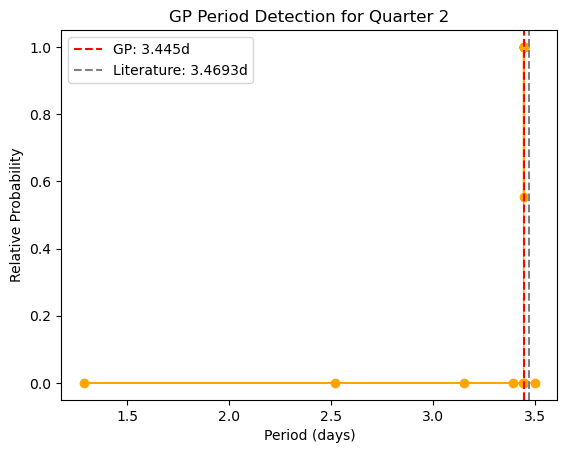

In [40]:
plt.plot(periods, probs, 'o-', color='orange', linewidth=1)
plt.xlabel('Period (days)')
plt.ylabel('Relative Probability')
plt.title('GP Period Detection for Quarter 2')
plt.axvline(gp_periods[1], color='red', linestyle='--', label=f'GP: {gp_periods[1]:.3f}d')
plt.axvline(3.4693, color='gray', linestyle='--', label='Literature: 3.4693d')
plt.legend()
plt.show()

## Visualize GP Fit - Everythign below this is not completed

Let's visualize the GP fit for the first quarter to see how well it captures the rotation signal.

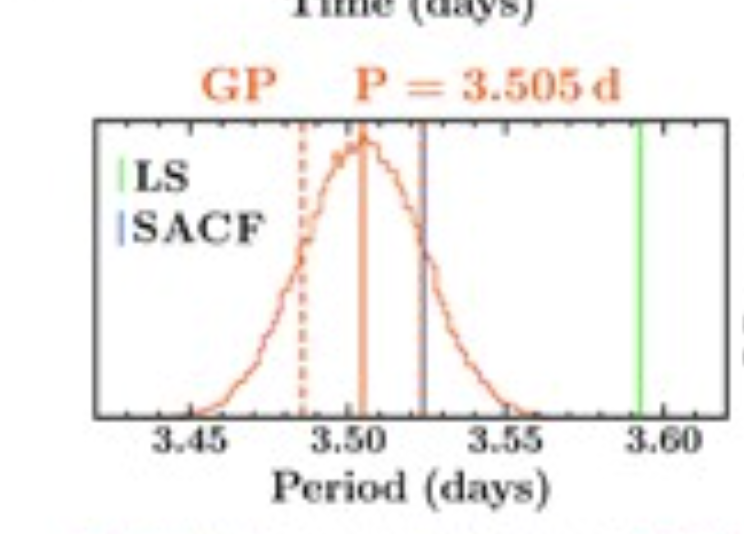  not sure how to get this

In [ ]:
# # Plot GP period posterior from optimization trajectory
# result = find_period_gp(light_curves[0], initial_period=3.5)

# periods = np.array(result['trajectory']['periods'])
# losses = np.array(result['trajectory']['losses'])

# # Convert loss to probability (normalize)
# log_probs = -losses
# probs = np.exp(log_probs - np.max(log_probs))

# # Plot
# plt.figure(figsize=(8, 5))
# plt.plot(periods, probs, 'o-', color='orange', linewidth=2, markersize=4, label='GP optimization path')
# plt.axvline(result['period'], color='orange', linestyle='-', linewidth=2, 
#             label=f"Final: {result['period']:.3f}d")
# plt.axvline(3.4693, color='gray', linestyle='--', linewidth=2, label='Literature: 3.469d')
# plt.xlabel('Period (days)')
# plt.ylabel('Relative Probability')
# plt.title('GP Period Optimization Trajectory')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

# print(f"GP detected period: {result['period']:.4f} days")
# print(f"Literature period: 3.4693 days")
# print(f"Difference: {abs(result['period'] - 3.4693):.4f} days")

<!-- ## Compare GP vs Lomb-Scargle Periods -->
<!-- <!--  -->
<!-- Let's phase-fold the data using both methods and compare the results. --> -->

In [ ]:
# # Compute Lomb-Scargle period for comparison
# lc_q1 = light_curves[0]
# time = lc_q1.time.value
# flux = lc_q1.flux.value
# mask = np.isfinite(time) & np.isfinite(flux)
# time = time[mask]
# flux = flux[mask]

# # Normalize
# flux_norm = flux / np.nanmedian(flux)

# # Lomb-Scargle
# ls = LombScargle(time, flux_norm)
# frequency, power = ls.autopower(minimum_frequency=1/10, maximum_frequency=1/2)
# best_freq = frequency[np.argmax(power)]
# ls_period = 1 / best_freq

# print(f"Lomb-Scargle period: {ls_period:.4f} days")
# print(f"GP period: {result_q1['period']:.4f} days")
# print(f"Literature period: 3.4693 days")

# # Phase folding function with binning
# def plot_phase_folded_comparison(lc, periods, labels, nbins=200):
#     """Compare phase-folded curves for different periods"""
    
#     fig, axes = plt.subplots(1, len(periods), figsize=(6*len(periods), 5))
#     if len(periods) == 1:
#         axes = [axes]
    
#     # Extract data
#     time = lc.time.value
#     flux = lc.flux.value
#     mask = np.isfinite(time) & np.isfinite(flux)
#     time = time[mask]
#     flux = flux[mask]
#     flux_norm = flux / np.nanmedian(flux)
    
#     for ax, period, label in zip(axes, periods, labels):
#         # Compute phase
#         phase = (time % period) / period
        
#         # Bin the data
#         bin_edges = np.linspace(0, 1, nbins + 1)
#         bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#         bin_means = []
        
#         for i in range(nbins):
#             mask_bin = (phase >= bin_edges[i]) & (phase < bin_edges[i+1])
#             if np.sum(mask_bin) > 0:
#                 bin_means.append(np.mean(flux_norm[mask_bin]))
#             else:
#                 bin_means.append(np.nan)
        
#         # Plot
#         ax.plot(bin_centers, bin_means, 'b-', linewidth=1.5)
#         ax.plot(bin_centers + 1, bin_means, 'b-', linewidth=1.5, alpha=0.5)
#         ax.set_xlabel('Phase')
#         ax.set_ylabel('Normalized Flux')
#         ax.set_title(f'{label}\nPeriod: {period:.4f} days')
#         ax.grid(True, alpha=0.3)
#         ax.set_xlim(0, 2)
    
#     plt.tight_layout()
#     plt.show()

# # Compare the three periods
# plot_phase_folded_comparison(
#     lc_q1, 
#     [3.4693, ls_period, result_q1['period']], 
#     ['Literature', 'Lomb-Scargle', 'Gaussian Process']
# )

## Period Distribution Across Quarters

Visualize how the detected period varies across different observing quarters.

In [ ]:
# # Plot period distribution
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# # Quarter-by-quarter periods
# quarters = np.arange(1, len(gp_periods) + 1)
# ax1.plot(quarters, gp_periods, 'o-', markersize=8, linewidth=2, label='GP periods')
# ax1.axhline(3.4693, color='red', linestyle='--', linewidth=2, label='Literature (3.4693 d)')
# ax1.axhline(np.mean(gp_periods), color='blue', linestyle=':', linewidth=2, 
#             label=f'Mean: {np.mean(gp_periods):.4f} d')
# ax1.fill_between(quarters, 
#                   np.mean(gp_periods) - np.std(gp_periods),
#                   np.mean(gp_periods) + np.std(gp_periods),
#                   alpha=0.2, color='blue')
# ax1.set_xlabel('Quarter')
# ax1.set_ylabel('Period [days]')
# ax1.set_title('GP Period Detection by Quarter')
# ax1.legend()
# ax1.grid(True, alpha=0.3)
# ax1.set_xticks(quarters)

# # Histogram
# ax2.hist(gp_periods, bins=15, alpha=0.7, edgecolor='black')
# ax2.axvline(3.4693, color='red', linestyle='--', linewidth=2, label='Literature')
# ax2.axvline(np.mean(gp_periods), color='blue', linestyle=':', linewidth=2, 
#             label=f'Mean GP: {np.mean(gp_periods):.4f} d')
# ax2.set_xlabel('Period [days]')
# ax2.set_ylabel('Count')
# ax2.set_title('Distribution of GP Periods')
# ax2.legend()
# ax2.grid(True, alpha=0.3, axis='y')

# plt.tight_layout()
# plt.show()

# # Print statistics
# print(f"Period statistics:")
# print(f"  Mean: {np.mean(gp_periods):.4f} days")
# print(f"  Std:  {np.std(gp_periods):.4f} days")
# print(f"  Min:  {np.min(gp_periods):.4f} days")
# print(f"  Max:  {np.max(gp_periods):.4f} days")
# print(f"  Literature: 3.4693 days")
# print(f"  Mean difference from literature: {abs(np.mean(gp_periods) - 3.4693):.4f} days")